This notebook demonstrates some ways of requesting and handling larger data volumes.

Note that the code could take a long time to run, so it is better to adjust it for smaller jobs if you are just testing it out.

In [2]:
from viresclient import SwarmRequest
import datetime as dt

# Set up the request parameters - magnetic data and model evaluations

Note that the code below will fetch the measurements (`F`, `B_NEC`), and model values (named as `F_CHAOS`, `B_NEC_CHAOS`) - here we name the custom model as "CHAOS" but you can call it anything.

It is also possible to fetch data from all satellites at once with `request.set_collection("SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", ""SW_OPER_MAGC_LR_1B")`, which will be identified in the returned data by the `Spacecraft` column.

In [2]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")  # Swarm Alpha
request.set_products(
    measurements=["F", "B_NEC"],
    # Choose between the full CHAOS model (will be a lot slower - the MMA part could use some optimisation(?))
#     models=["CHAOS = 'CHAOS-6-Core' + 'CHAOS-6-Static' + 'CHAOS-6-MMA-Primary' + 'CHAOS-6-MMA-Secondary'"],
    # ...or just the core part:
    models=["CHAOS = 'CHAOS-6-Core'"],
    sampling_step="PT1S"
)
# Quality Flags
# https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#label-Flags_F-and-Flags_B-Values-of-MDR_MAG_LR
# NB: will need to do something different for Charlie because the ASM broke so Flags_F are bad
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Flags_B", 0, 1)

# Look at one day to see what the output data will look like

In [3]:
data = request.get_between(
    start_time=dt.datetime(2018,1,1),
    end_time=dt.datetime(2018,1,2)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (8.212MB)


In [4]:
data.as_dataframe(expand=True).head()

,Spacecraft,Latitude,Longitude,Radius,F,F_CHAOS,B_NEC_N,B_NEC_E,B_NEC_C,B_NEC_CHAOS_N,B_NEC_CHAOS_E,B_NEC_CHAOS_C
2018-01-01 00:00:00,A,67.633961,171.372832,6808059.52,46592.0984,46590.202935,10359.2446,-187.2981,45425.4040,10358.937030,-153.381520,45423.737266
2018-01-01 00:00:01,A,67.570052,171.389161,6808066.03,46578.1323,46576.048406,10394.1152,-186.2339,45403.1172,10394.202973,-152.411189,45401.162986
2018-01-01 00:00:02,A,67.506140,171.405378,6808072.56,46564.0862,46561.812766,10429.4246,-184.7463,45380.5991,10429.450713,-151.433387,45378.475447
2018-01-01 00:00:03,A,67.442226,171.421486,6808079.11,46549.9552,46547.496040,10464.5537,-183.3768,45358.0147,10464.679869,-150.448125,45355.674708
2018-01-01 00:00:04,A,67.378309,171.437486,6808085.67,46535.7412,46533.098437,10499.3677,-182.4300,45335.4015,10499.890161,-149.455429,45332.760999


In [5]:
data.as_xarray()

<xarray.Dataset>
Dimensions:      (Timestamp: 84595, dim: 3)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2018-01-01 ... 2018-01-01T23:59:59
Dimensions without coordinates: dim
Data variables:
    Spacecraft   (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude     (Timestamp) float64 67.63 67.57 67.51 ... -81.72 -81.78 -81.84
    Longitude    (Timestamp) float64 171.4 171.4 171.4 ... -164.9 -164.8 -164.7
    Radius       (Timestamp) float64 6.808e+06 6.808e+06 ... 6.825e+06 6.825e+06
    F            (Timestamp) float64 4.659e+04 4.658e+04 ... 4.706e+04 4.704e+04
    F_CHAOS      (Timestamp) float64 4.659e+04 4.658e+04 ... 4.712e+04 4.71e+04
    B_NEC        (Timestamp, dim) float64 1.036e+04 -187.3 ... -4.583e+04
    B_NEC_CHAOS  (Timestamp, dim) float64 1.036e+04 -153.4 ... -4.592e+04
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20180101T000000_20180101T235959_050...
    MagneticModels:  ["CHAOS = 'CHAOS-6-Core'(max_degree=20,min_degree=

# Three options suggested for how to deal with larger volumes

# 1. Fetch five years of data and save them directly

For this example I will simplify the acquired data

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")  # Swarm Alpha
request.set_products(
    measurements=["F"],
    sampling_step="PT5S"
)
# Quality Flags
# https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#label-Flags_F-and-Flags_B-Values-of-MDR_MAG_LR
# NB: will need to do something different for Charlie because the ASM broke so Flags_F are bad
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Flags_B", 0, 1)

The request is automatically split up and sequentially processed.

In [7]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2019,1,1)
)

[1/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (165.873MB)
[2/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (174.037MB)
[3/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (174.4MB)
[4/8] Processing:  100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:12, Remaining: 00:00 ] (174.176MB)
[5/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (173.071MB)
[6/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:13, Remaining: 00:00 ] (174.317MB)
[7/8] Processing:  100%|██████████|  [ Ela

`data` is a kind of wrapper around some temporary CDF files (more data -> more files). This means the data is accessible but not yet loaded into memory. When the variable `data` is deleted, or the current program is closed, the files will be removed. `data.contents` is a list of objects which point to each file, and each on-disk filename can be retrieved as below.

Note that this behaviour is likely to change in the future.

In [8]:
data.contents[0]._file.name

'/tmp/vires_dncjprgo'

`data.as_dataframe()` / `data.as_xarray()` will read the files and concatenate them, but will fail if you don't have the memory to load them all simultaneously.

### Save the files directly

The length of `data.contents` tells us the number of temporary files. Use this to make up some file names to give them.

In [9]:
filenames = [f"testfile_{n:03}.cdf" for n in range(len(data.contents))]
filenames

['testfile_000.cdf',
 'testfile_001.cdf',
 'testfile_002.cdf',
 'testfile_003.cdf',
 'testfile_004.cdf',
 'testfile_005.cdf',
 'testfile_006.cdf',
 'testfile_007.cdf']

In [10]:
data.to_files(filenames)

Data written to testfile_000.cdf
Data written to testfile_001.cdf
Data written to testfile_002.cdf
Data written to testfile_003.cdf
Data written to testfile_004.cdf
Data written to testfile_005.cdf
Data written to testfile_006.cdf
Data written to testfile_007.cdf


From here you may use some other tool to work with the files. I will just remove them now:

In [11]:
!rm testfile_*

# 2. Tune the size of each generated file by making multiple requests manually

Generate lists of start and end times to use...

In [12]:
start_times = []
end_times = []
start = dt.datetime(2014, 1, 1)
end = start + dt.timedelta(days=1)
while end <= dt.datetime(2014, 2, 1):
#     print(start, end)
    start_times.append(start)
    end_times.append(end)
    start, end = end, end + dt.timedelta(days=1)
    
list(zip(start_times, end_times))

[(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 1, 2, 0, 0)),
 (datetime.datetime(2014, 1, 2, 0, 0), datetime.datetime(2014, 1, 3, 0, 0)),
 (datetime.datetime(2014, 1, 3, 0, 0), datetime.datetime(2014, 1, 4, 0, 0)),
 (datetime.datetime(2014, 1, 4, 0, 0), datetime.datetime(2014, 1, 5, 0, 0)),
 (datetime.datetime(2014, 1, 5, 0, 0), datetime.datetime(2014, 1, 6, 0, 0)),
 (datetime.datetime(2014, 1, 6, 0, 0), datetime.datetime(2014, 1, 7, 0, 0)),
 (datetime.datetime(2014, 1, 7, 0, 0), datetime.datetime(2014, 1, 8, 0, 0)),
 (datetime.datetime(2014, 1, 8, 0, 0), datetime.datetime(2014, 1, 9, 0, 0)),
 (datetime.datetime(2014, 1, 9, 0, 0), datetime.datetime(2014, 1, 10, 0, 0)),
 (datetime.datetime(2014, 1, 10, 0, 0), datetime.datetime(2014, 1, 11, 0, 0)),
 (datetime.datetime(2014, 1, 11, 0, 0), datetime.datetime(2014, 1, 12, 0, 0)),
 (datetime.datetime(2014, 1, 12, 0, 0), datetime.datetime(2014, 1, 13, 0, 0)),
 (datetime.datetime(2014, 1, 13, 0, 0), datetime.datetime(2014, 1, 14

Generate some file names to use

In [13]:
filenames = [f"data_{start.strftime('%Y-%m-%d')}.cdf" for start in start_times]
filenames

['data_2014-01-01.cdf',
 'data_2014-01-02.cdf',
 'data_2014-01-03.cdf',
 'data_2014-01-04.cdf',
 'data_2014-01-05.cdf',
 'data_2014-01-06.cdf',
 'data_2014-01-07.cdf',
 'data_2014-01-08.cdf',
 'data_2014-01-09.cdf',
 'data_2014-01-10.cdf',
 'data_2014-01-11.cdf',
 'data_2014-01-12.cdf',
 'data_2014-01-13.cdf',
 'data_2014-01-14.cdf',
 'data_2014-01-15.cdf',
 'data_2014-01-16.cdf',
 'data_2014-01-17.cdf',
 'data_2014-01-18.cdf',
 'data_2014-01-19.cdf',
 'data_2014-01-20.cdf',
 'data_2014-01-21.cdf',
 'data_2014-01-22.cdf',
 'data_2014-01-23.cdf',
 'data_2014-01-24.cdf',
 'data_2014-01-25.cdf',
 'data_2014-01-26.cdf',
 'data_2014-01-27.cdf',
 'data_2014-01-28.cdf',
 'data_2014-01-29.cdf',
 'data_2014-01-30.cdf',
 'data_2014-01-31.cdf']

### NB: BUG: the server request is failing on some days when there is no data available for the whole day (at least I think that is the problem...) - catch these with a RuntimeError

In [14]:
for start, end, filename in zip(start_times, end_times, filenames):
    try:
        request.get_between(start, end).to_file(filename, overwrite=True)
    except RuntimeError:
        print(f"No data for {filename} - file not created")

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-01.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-02.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.702MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-03.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.271MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-04.cdf



[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

No data for data_2014-01-05.cdf - file not created



[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

No data for data_2014-01-06.cdf - file not created


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.137MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-07.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.264MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-08.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-09.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.699MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-10.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-11.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-12.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-13.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-14.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-15.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.691MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-16.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-17.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.696MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-18.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.004MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-19.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.701MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-20.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.695MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-21.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.679MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-22.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.628MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-23.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.613MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-24.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-25.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-26.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.708MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-27.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.5MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-28.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.494MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-29.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Data written to data_2014-01-30.cdf


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.674MB)


Data written to data_2014-01-31.cdf


In [15]:
!rm data_2014*.cdf

# 3. Use viresclient to translate the data from CDF to pandas/xarray then to netCDF

There are some nicer tools for working with netCDF4/HDF files in Python so this may be preferable

### NB: when there is no data, sometimes there's a RuntimeError (i.e. server issue), or the created xarray Dataset is actually `None` (maybe an undesired outcome?) - catch these with AttributeError when trying to `.to_netcdf()`

In [17]:
filenames_nc = [f"data_{start.strftime('%Y-%m-%d')}.nc" for start in start_times]

for start, end, filename in zip(start_times, end_times, filenames_nc):
    try:
        ds = request.get_between(start, end).as_xarray()
        print(f"saved {filename}")
    except RuntimeError:
        print(f"No data for {filename} - data not downloaded")
    try:
        ds.to_netcdf(filename)
    except AttributeError:
        print(f"No data for {filename} - file not created")

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-01.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-02.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.702MB)


saved data_2014-01-03.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.271MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

saved data_2014-01-04.nc



[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

No data for data_2014-01-05.nc - data not downloaded



[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

No data for data_2014-01-06.nc - data not downloaded


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.137MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

saved data_2014-01-07.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.264MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

saved data_2014-01-08.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)


saved data_2014-01-09.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.699MB)


saved data_2014-01-10.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)


saved data_2014-01-11.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-12.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-13.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.698MB)


saved data_2014-01-14.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-15.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.691MB)


saved data_2014-01-16.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-17.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.696MB)


saved data_2014-01-18.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.004MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

(This part is likely empty)
saved data_2014-01-19.nc
No data for data_2014-01-19.nc - file not created


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.701MB)


saved data_2014-01-20.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.695MB)


saved data_2014-01-21.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.679MB)


saved data_2014-01-22.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.628MB)


saved data_2014-01-23.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.613MB)


saved data_2014-01-24.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-25.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-26.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.708MB)


saved data_2014-01-27.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.5MB)


saved data_2014-01-28.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.494MB)


saved data_2014-01-29.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.703MB)


saved data_2014-01-30.nc


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.674MB)


saved data_2014-01-31.nc


### Use xarray+dask to lazily load the data

See https://xarray.pydata.org/en/stable/dask.html

In [18]:
from xarray import open_mfdataset
%matplotlib inline

In [20]:
ds = open_mfdataset("data_2014*.nc", combine="by_coords")
ds

<xarray.Dataset>
Dimensions:     (Timestamp: 425322)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) object dask.array<shape=(425322,), chunksize=(17038,)>
    Latitude    (Timestamp) float64 dask.array<shape=(425322,), chunksize=(17038,)>
    Longitude   (Timestamp) float64 dask.array<shape=(425322,), chunksize=(17038,)>
    Radius      (Timestamp) float64 dask.array<shape=(425322,), chunksize=(17038,)>
    F           (Timestamp) float64 dask.array<shape=(425322,), chunksize=(17038,)>
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_050...
    MagneticModels:  []
    RangeFilters:    ['Flags_B:0,1', 'Flags_F:0,1']

### Warning: I haven't tested this out properly. Theres a bug in the behaviour of the metadata

In [21]:
ds.Sources

['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_0505_MDR_MAG_LR',
 'SW_OPER_MAGA_LR_1B_20140102T000000_20140102T235959_0505_MDR_MAG_LR']

/home/ash/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


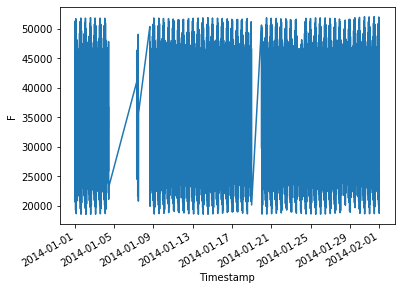

In [22]:
ds["F"].plot();

In [23]:
!rm data_2014*.nc

# ... getting 2014-19 and converting to netCDF using the automatically split files

In [4]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2019,1,1)
)

[1/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:17, Remaining: 00:00 ] (165.873MB)
[2/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:12, Remaining: 00:00 ] (174.037MB)
[3/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (174.4MB)
[4/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:13, Remaining: 00:00 ] (174.176MB)
[5/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:12, Remaining: 00:00 ] (173.071MB)
[6/8] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:12, Remaining: 00:00 ] (174.317MB)
[7/8] Processing:  100%|██████████|  [ Ela

### It is possible to access each file and load as xarray Dataset (rather than automatically concatenating them all)

### This could be a problem if the sizes are too large for your machine. It is also rather slow!

### BUG: the metadata isn't added in this case

In [5]:
data.contents[0].as_xarray()

<xarray.Dataset>
Dimensions:     (Timestamp: 4043952)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-09-07T23:59:55
Data variables:
    Spacecraft  (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude    (Timestamp) float64 -1.229 -1.546 -1.863 ... 54.96 55.28 55.6
    Longitude   (Timestamp) float64 -14.12 -14.12 -14.13 ... -165.2 -165.2
    Radius      (Timestamp) float64 6.878e+06 6.878e+06 ... 6.834e+06 6.834e+06
    F           (Timestamp) float64 2.287e+04 2.284e+04 ... 4.207e+04 4.22e+04

In [8]:
%%time
filenames = [f"testfile_{n:03}.nc" for n in range(len(data.contents))]
for data_part, filename in zip(data.contents, filenames):
    data_part.as_xarray().to_netcdf(filename)

CPU times: user 21min 1s, sys: 15.2 s, total: 21min 16s
Wall time: 21min 15s


In [14]:
ds = open_mfdataset("testfile*.nc", combine="by_coords")
ds

<xarray.Dataset>
Dimensions:     (Timestamp: 30728063)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2018-12-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) object dask.array<shape=(30728063,), chunksize=(4043952,)>
    Latitude    (Timestamp) float64 dask.array<shape=(30728063,), chunksize=(4043952,)>
    Longitude   (Timestamp) float64 dask.array<shape=(30728063,), chunksize=(4043952,)>
    Radius      (Timestamp) float64 dask.array<shape=(30728063,), chunksize=(4043952,)>
    F           (Timestamp) float64 dask.array<shape=(30728063,), chunksize=(4043952,)>

In [15]:
!rm testfile*.nc